In [1]:
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information astropy, numpy, scipy, matplotlib, astroquery, photutils, version_information
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

This notebook was generated at 2023-05-04 17:58:55 (KST = GMT+0900) 


0 Python     3.10.10 64bit [Clang 14.0.6 ]
1 IPython    8.13.1
2 OS         macOS 13.1 arm64 arm 64bit
3 astropy    5.2.2
4 numpy      1.23.5
5 scipy      1.10.1
6 matplotlib 3.7.1
7 astroquery 0.4.7.dev8639
8 photutils  1.7.0
9 version_information 1.0.4


In [2]:
from IPython.core.interactiveshell import InteractiveShell
from IPython import get_ipython
%config InlineBackend.figure_format = 'retina'
InteractiveShell.ast_node_interactivity = 'last_expr'
ipython = get_ipython()
from pathlib import Path

import numpy as np

from matplotlib import pyplot as plt
from matplotlib import rcParams

from astropy.io import fits
from astropy.stats import sigma_clipped_stats, SigmaClip

from photutils.aperture import CircularAnnulus as CAn
from photutils.aperture import CircularAperture as CAp
from photutils.centroids import centroid_com
from photutils.background import Background2D, MedianBackground, SExtractorBackground

import sep

from astropy.visualization import ZScaleInterval, ImageNormalize

def colorbaring(fig, ax, im):
    cb = fig.colorbar(im, ax=ax, orientation='horizontal')
    cb.ax.set_xticklabels(cb.get_ticks().astype(int), rotation=45)

def znorm(image):
    return ImageNormalize(image, interval=ZScaleInterval())

def zimshow(ax, image, **kwargs):
    return ax.imshow(image, norm=znorm(image), origin='lower', **kwargs)

FIGPATH = Path("figs")
DATAPATH = Path("../../Tutorial_Data")
fpath = DATAPATH/"SNUO_STX16803-kw4-4-4-20190602-135247-R-60.0_bdfw.fits"

/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_45371/1986792057.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_xticklabels(cb.get_ticks().astype(int), rotation=45)


No mesh (pad) is masked 


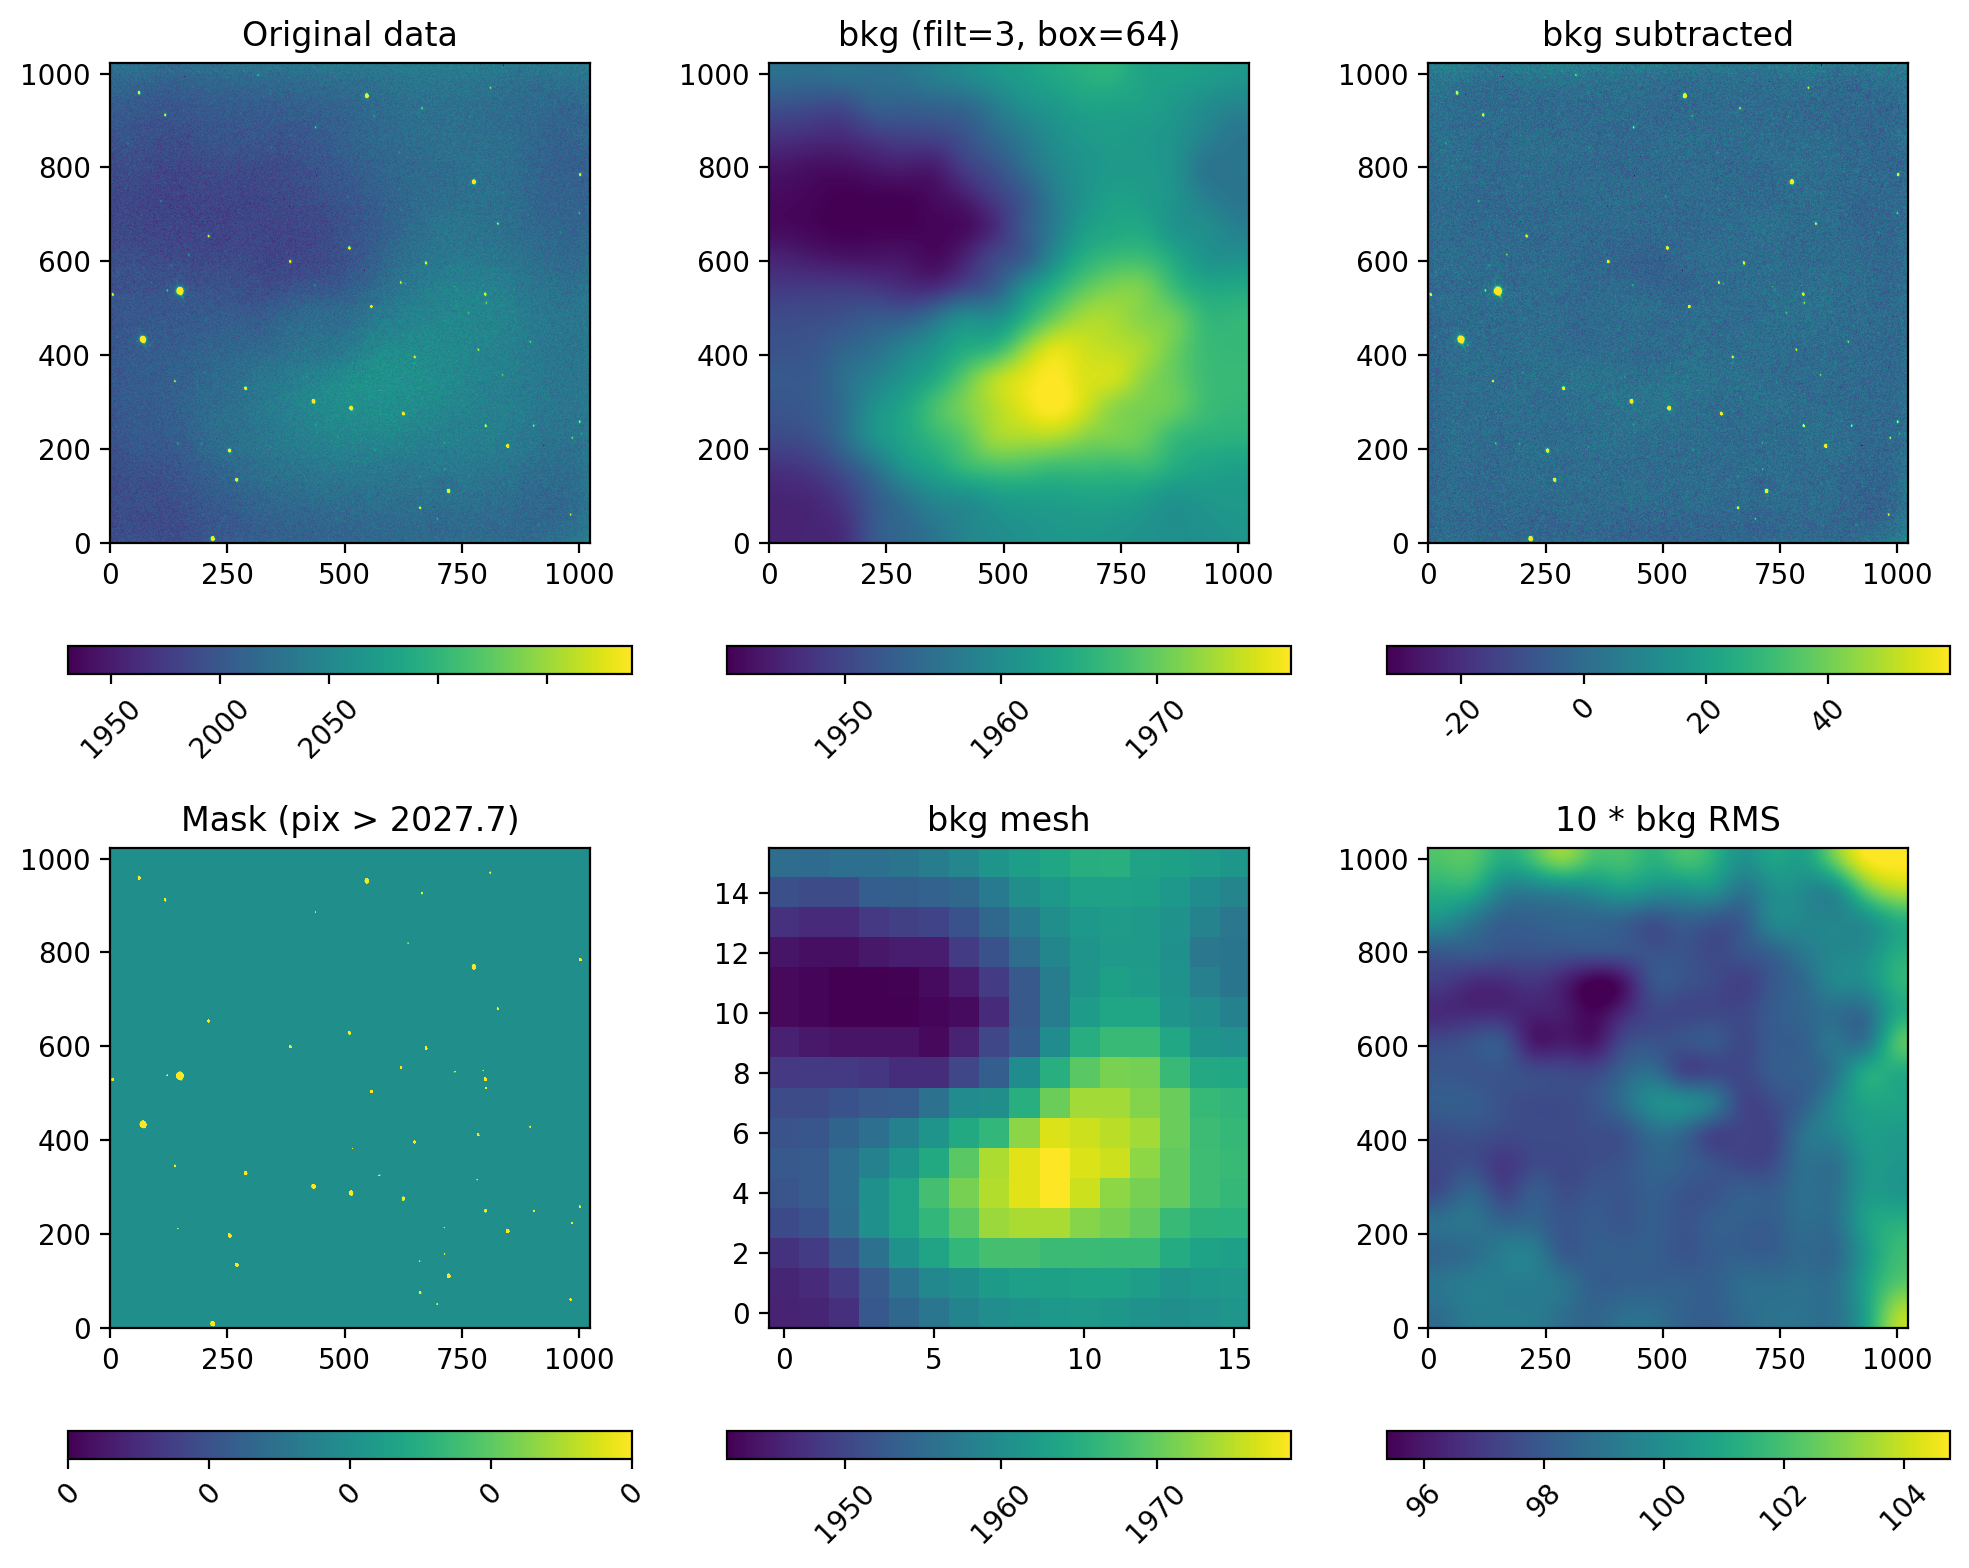

In [3]:
box = 64
filt = 3

bkg_path = fpath.parent / (fpath.name[:-5] + '_bkg.png')
png_path = fpath.parent / (fpath.name[:-5] + '.png')
hdu = fits.open(fpath)[0]
data = hdu.data

avg, med, std = sigma_clipped_stats(data, sigma=3, maxiters=5)
thresh = med + 5 * std
mask = (data > thresh)  # mask = True when pixel has high signal (possibly a celestial object)

bkg_sex = Background2D(
    data,
    box_size=box,
    mask=mask,
    filter_size=filt,
    exclude_percentile=2,
    sigma_clip=SigmaClip(sigma=3, maxiters=5, cenfunc='median', stdfunc='std')
)
bkgsub_sex = data - bkg_sex.background

fig, axs = plt.subplots(2, 3, figsize=(10, 8))

data2plot = [
    dict(ax=axs[0, 0], arr=data, title="Original data"),
    dict(ax=axs[0, 1], arr=bkg_sex.background, title=f"bkg (filt={filt:d}, box={box:d})"),
    dict(ax=axs[0, 2], arr=bkgsub_sex, title="bkg subtracted"),
    dict(ax=axs[1, 0], arr=mask, title=f"Mask (pix > {thresh:.1f})"),
    dict(ax=axs[1, 1], arr=bkg_sex.background_mesh, title="bkg mesh"),
    dict(ax=axs[1, 2], arr=10*bkg_sex.background_rms, title="10 * bkg RMS")
]

for dd in data2plot:
    im = zimshow(dd['ax'], dd['arr'])
    colorbaring(fig, dd['ax'], im)
    dd['ax'].set_title(dd['title'])

try:
    axs[1, 1].plot(*np.where(bkg_sex.background_mesh_ma.mask == True), 'rx', ms=10)
except AttributeError:
    print("No mesh (pad) is masked ")

plt.tight_layout()
plt.savefig(FIGPATH / "sex_bkg_01.png", bbox_inches='tight')